<a href="https://colab.research.google.com/github/LonelyFriday/Predict_PTT_stock_by_RNNs/blob/main/Predict_PTT_stock_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
## import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data: PTT stock price 

*   Period: 2011/01/04 - 2021/03/12 
*   Rows: 2,490 
*   Columns: 6



In [26]:
df = pd.read_csv('https://raw.githubusercontent.com/LonelyFriday/Predict_PTT_stock_by_RNNs/main/ptt.csv', parse_dates=True, index_col='Date')
df

,recent,open,high,low,volume,percent
Date,,,,,,
2011-01-04,33.00,32.50,33.30,32.30,105.95M,3.13%
2011-01-05,33.20,33.00,33.20,32.80,52.61M,0.61%
2011-01-06,33.20,33.30,33.40,32.90,39.65M,0.00%
2011-01-07,32.20,33.10,33.10,32.20,55.19M,-3.01%
2011-01-10,31.80,32.10,32.20,31.60,83.62M,-1.24%
...,...,...,...,...,...,...
2021-03-08,42.00,41.50,42.50,41.50,126.62M,3.70%
2021-03-09,41.25,42.25,42.25,41.00,95.15M,-1.79%
2021-03-10,41.50,41.00,41.50,40.75,79.87M,0.61%


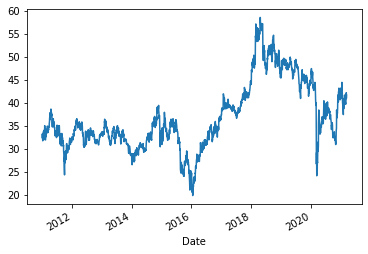

In [29]:
## we use Open price as data
df['open'].plot()

## Scaling data

*   Normalization: [0, 1]



In [43]:
from sklearn.preprocessing import MinMaxScaler

In [53]:
sc = MinMaxScaler()
df_sc = sc.fit_transform(df['open'][:-12].values.reshape(-1, 1))

## Reshape


*   2D -> 3D



In [111]:
X_train = []
Y_train = []

for i in range(60, len(df_sc)):
  X_train.append(df_sc[i-60:i])
  Y_train.append(df_sc[i])

X_train, Y_train = np.array(X_train), np.array(Y_train)

In [152]:
print('Dimension of X_train:', X_train.shape)
print('Dimension of Y_train:', Y_train.shape, '** we do not need to reshape Y_train to 3D **')

Dimension of X_train: (2418, 60, 1)
Dimension of Y_train: (2418, 1) ** we do not need to reshape Y_train to 3D **


## Model: LSTM

*   2 hidden layer 
*   dropout at 20%
*   optimizer = adam
*   measure = Mean Square Error, Root Mean Square Error





In [94]:
## import library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import RootMeanSquaredError

In [115]:
model = Sequential()

In [116]:
model.add(LSTM(units=120, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=120, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(Dense(units=1))

In [117]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError()])

## Train model

*   epochs = 10 รอบ
*   batch_size = 32 ชุด



In [118]:
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
76/76 [==============================] - 12s 117ms/step - loss: 0.0281 - root_mean_squared_error: 0.1541
Epoch 2/10
76/76 [==============================] - 9s 116ms/step - loss: 0.0025 - root_mean_squared_error: 0.0499
Epoch 3/10
76/76 [==============================] - 9s 115ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486
Epoch 4/10
76/76 [==============================] - 9s 115ms/step - loss: 0.0021 - root_mean_squared_error: 0.0463
Epoch 5/10
76/76 [==============================] - 9s 115ms/step - loss: 0.0018 - root_mean_squared_error: 0.0429
Epoch 6/10
76/76 [==============================] - 9s 115ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412
Epoch 7/10
76/76 [==============================] - 9s 116ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412
Epoch 8/10
76/76 [==============================] - 9s 115ms/step - loss: 0.0016 - root_mean_squared_error: 0.0403
Epoch 9/10
76/76 [==============================] - 9s 116ms/step - loss: 0.001

## Predict

*   Predict with X_train
*   Forecast with X_test (12 days)



In [119]:
## Prepare X_test: last 12 days 
X_test_sc = sc.transform(df['open'][-72:].values.reshape(-1, 1))

X_test = []
Y_test = []

for i in range(60, len(X_test_sc)):
  X_test.append(X_test_sc[i-60:i])
  Y_test.append(X_test_sc[i])

X_test, Y_test = np.array(X_test), sc.inverse_transform(np.array(Y_test))

In [132]:
## Remove first 60 days, because the model can't predict these day
df = df[60:]

In [136]:
## Append the column: predict in the dataframe
df['predict'] = np.append(sc.inverse_transform(model.predict(X_train)), sc.inverse_transform(model.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [137]:
## new Dataframe 
df

,recent,open,high,low,volume,percent,predict
Date,,,,,,,
2011-03-30,35.20,34.80,35.20,34.80,55.06M,1.73%,34.680637
2011-03-31,35.40,35.30,35.50,35.00,43.96M,0.57%,34.783134
2011-04-01,35.70,35.60,36.00,35.50,46.93M,0.85%,34.918678
2011-04-04,36.80,36.10,36.80,36.10,60.64M,3.08%,35.093548
2011-04-05,36.80,36.70,36.80,36.60,23.79M,0.00%,35.332344
...,...,...,...,...,...,...,...
2021-03-08,42.00,41.50,42.50,41.50,126.62M,3.70%,39.962135
2021-03-09,41.25,42.25,42.25,41.00,95.15M,-1.79%,40.164761
2021-03-10,41.50,41.00,41.50,40.75,79.87M,0.61%,40.546127


## Line plot only last 12 days (Test set) 

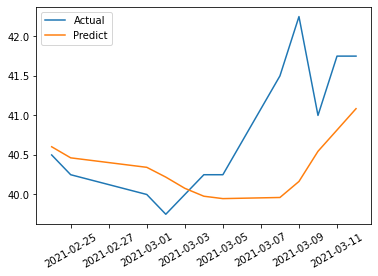

In [142]:
plt.plot(df.open[-12:], label='Actual')
plt.plot(df.predict[-12:], label='Predict')
plt.xticks(rotation=30)
plt.legend()
plt.show()

## Line plot from 2011/03/30 until 2021-03-12

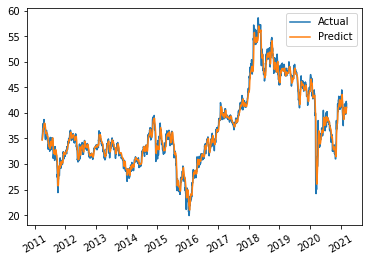

In [143]:
plt.plot(df.open, label='Actual')
plt.plot(df.predict, label='Predict')
plt.xticks(rotation=30)
plt.legend()
plt.show()

## Measurement: Root mean square error (RMSE)

*   unit in Thai Baht



In [144]:
## import library
from sklearn.metrics import mean_squared_error

In [157]:
print('RMSE on Train set:                   ', round(mean_squared_error(df.open[:-12], df.predict[:-12], squared=False), 2), 'Baht')
print('RMSE on Test set (last 12 days):     ', round(mean_squared_error(df.open[-12:], df.predict[-12:], squared=False), 2), 'Baht')
print('RMSE on 2011/03/30 until 2021/03/12: ', round(mean_squared_error(df.open[:], df.predict[:], squared=False), 2), 'Baht')

RMSE on Train set:                    1.06 Baht
RMSE on Test set (last 12 days):      0.86 Baht
RMSE on 2011/03/30 until 2021/03/12:  1.06 Baht
